In [2]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

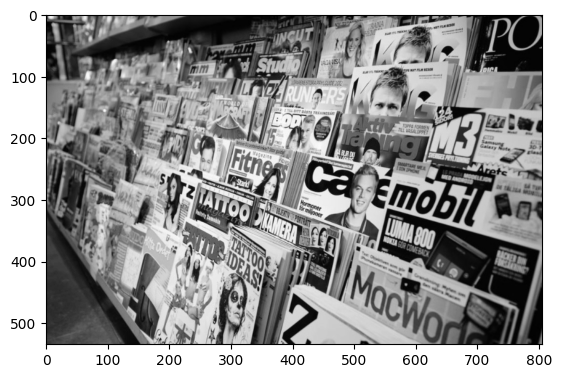

In [3]:
img = cv2.imread("images/magazines.jpg", flags=cv2.IMREAD_GRAYSCALE)

# Downsize image by factor of 8
height, width = img.shape
max_dim = max(height, width)
max_allowed_dim = 806
scale_factor = max_allowed_dim / max_dim
new_height, new_width = int(height * scale_factor), int(width * scale_factor)
img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # Normalize the image to 0-255

og_img = img.copy()

plt.imshow(img,cmap='gray')

177
70
3


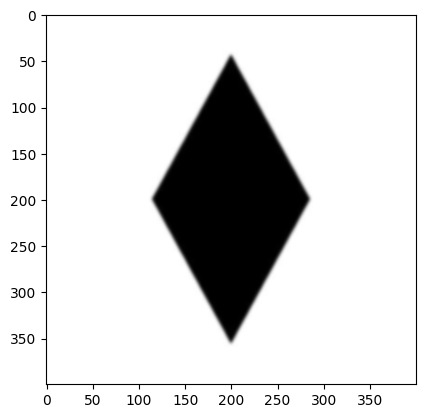

In [14]:
print(og_img[49, 196])
print(og_img[50, 196])
print(og_img[51, 196])

blurred_img = cv2.GaussianBlur(og_img, (0,0), 1.6)
plt.imshow(blurred_img, cmap='gray')
plt.show()


In [15]:
# DEFINE PARAMETERS (Copied from Lowe's paper)
num_octaves = 4
s = 3 # number of intervals per octave
sigma_init = 1.6 # initial sigma
k = 2**(1/s) # sigma multiplier

# Initial blur of the image
img_blur = cv2.GaussianBlur(img, (0,0), sigma_init)

In [16]:
# Precompute incremental sigmas similar to OpenCV
sigmas = [sigma_init]
for i in range(1, s + 3):
    sig_prev = sigma_init * (k ** (i - 1))
    sig_total = sig_prev * k
    sigmas.append((sig_total**2 - sig_prev**2) ** 0.5)

gaussian_pyramid = [[] for _ in range(num_octaves)]
gaussian_pyramid[0].append(img_blur)  # base image

for octave in range(num_octaves):
    if octave > 0:
        # Downsample the last blurred image from previous octave (index s)
        img_prev_oct = gaussian_pyramid[octave - 1][s]
        # img_down = cv2.resize(img_prev_oct, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
        img_down = cv2.pyrDown(img_prev_oct)
        gaussian_pyramid[octave].append(img_down)
        img_blur = img_down

    for i in range(1, s + 3):
        img_blur = cv2.GaussianBlur(img_blur, (0, 0), sigmas[i])
        gaussian_pyramid[octave].append(img_blur)


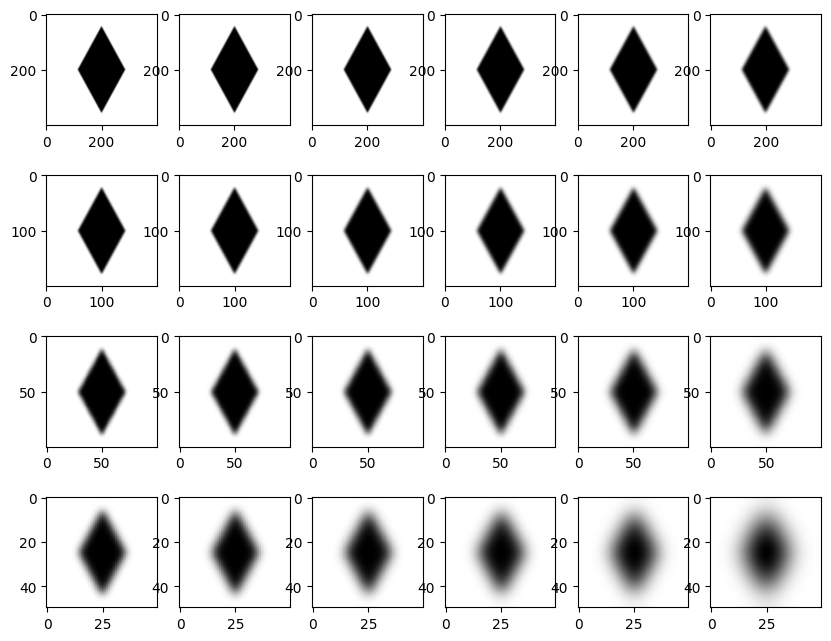

In [17]:
fig, axes = plt.subplots(num_octaves, s + 3, figsize=(2*(s + 2), 2*num_octaves))

for octave_idx, octave_images in enumerate(gaussian_pyramid):
    for img_idx, img in enumerate(octave_images):
        ax = axes[octave_idx, img_idx]
        ax.imshow(img, cmap='gray')

In [18]:
# Compute DoG pyramid
dog_pyramid = [[] for _ in range(num_octaves)]

for octave in range(num_octaves):
    for i in range(s + 2):
        dog_pyramid[octave].append(gaussian_pyramid[octave][i+1] - gaussian_pyramid[octave][i])

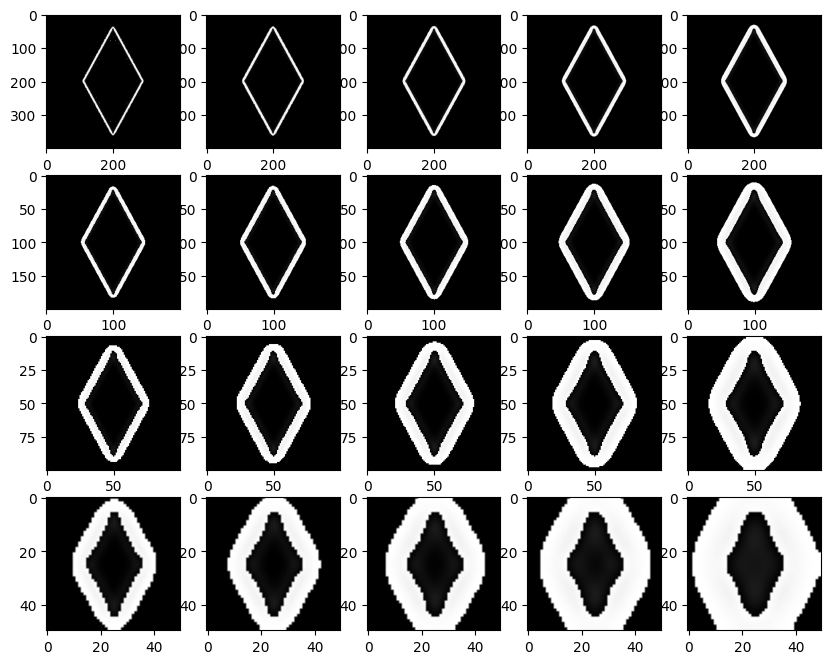

In [19]:
# Plot DoG pyramid
fig, axes = plt.subplots(num_octaves, s + 2, figsize=(2*(s + 2), 2*num_octaves))

for octave_idx, octave_images in enumerate(dog_pyramid):
    for img_idx, img in enumerate(octave_images):
        ax = axes[octave_idx, img_idx]
        ax.imshow(img, cmap='gray')

In [20]:
# Get keypoints (Local extrema)
keypoints = []

for octave in range(num_octaves):
    for img in range(s + 2):
        for (x,y) in np.ndindex(dog_pyramid[octave][img].shape):
            if x == 0 or x == dog_pyramid[octave][img].shape[0] - 1 or y == 0 or y == dog_pyramid[octave][img].shape[1] - 1:
                continue # Skip the edges
            if img == s + 1 or img == 0:
                continue
            # Get the values of the 26 neighbors of the pixel
            neighbors_at_level = [] # 8 neighbors at the same level
            neighbors_at_level.append(dog_pyramid[octave][img][x, y+1])
            neighbors_at_level.append(dog_pyramid[octave][img][x, y-1])
            neighbors_at_level.append(dog_pyramid[octave][img][x+1, y])
            neighbors_at_level.append(dog_pyramid[octave][img][x-1, y])
            neighbors_at_level.append(dog_pyramid[octave][img][x+1, y+1])
            neighbors_at_level.append(dog_pyramid[octave][img][x-1, y-1])
            neighbors_at_level.append(dog_pyramid[octave][img][x+1, y-1])
            neighbors_at_level.append(dog_pyramid[octave][img][x-1, y+1])
            

            neighbors_above = [] # 9 neighbors above
            neighbors_above.append(dog_pyramid[octave][img + 1][x, y])
            neighbors_above.append(dog_pyramid[octave][img + 1][x, y+1])
            neighbors_above.append(dog_pyramid[octave][img + 1][x, y-1])
            neighbors_above.append(dog_pyramid[octave][img + 1][x+1, y])
            neighbors_above.append(dog_pyramid[octave][img + 1][x-1, y])
            neighbors_above.append(dog_pyramid[octave][img + 1][x+1, y+1])
            neighbors_above.append(dog_pyramid[octave][img + 1][x-1, y-1])
            neighbors_above.append(dog_pyramid[octave][img + 1][x+1, y-1])
            neighbors_above.append(dog_pyramid[octave][img + 1][x-1, y+1])

        
            neighbors_below = [] # 9 neighbors below
            neighbors_below.append(dog_pyramid[octave][img - 1][x, y])
            neighbors_below.append(dog_pyramid[octave][img - 1][x, y+1])
            neighbors_below.append(dog_pyramid[octave][img - 1][x, y-1])
            neighbors_below.append(dog_pyramid[octave][img - 1][x+1, y])
            neighbors_below.append(dog_pyramid[octave][img - 1][x-1, y])
            neighbors_below.append(dog_pyramid[octave][img - 1][x+1, y+1])
            neighbors_below.append(dog_pyramid[octave][img - 1][x-1, y-1])
            neighbors_below.append(dog_pyramid[octave][img - 1][x+1, y-1])
            neighbors_below.append(dog_pyramid[octave][img - 1][x-1, y+1])
    
            # Concat all neighbors
            neighbors = np.concatenate([neighbors_at_level, neighbors_above, neighbors_below])

            # Check if the pixel is a local extremum
            if dog_pyramid[octave][img][x, y] > np.max(neighbors) or dog_pyramid[octave][img][x, y] < np.min(neighbors):
                octave_idx = img
                keypoints.append((x, y, octave, octave_idx))


print(len(keypoints))

447


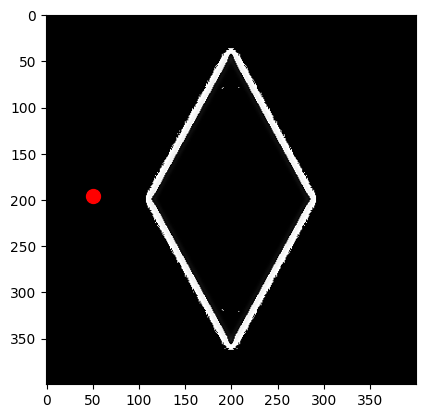

(49, 196, 0, 1)
4
0
8


In [21]:
# Plot DOG pyramid [0][1]
plt.imshow(dog_pyramid[0][1], cmap='gray')
plt.scatter(50, 196, color='red', s=100)
plt.show()

print(keypoints[0])
print(dog_pyramid[0][1][50, 196])

print(dog_pyramid[0][1][49, 196])

print(dog_pyramid[0][1][51, 196])



In [22]:
def compute_gradient(x, y, octave, octave_idx, dog_pyramid):
    dx = (dog_pyramid[octave][octave_idx][x+1, y].astype(np.float32) - dog_pyramid[octave][octave_idx][x-1, y].astype(np.float32)) / 2
    dy = (dog_pyramid[octave][octave_idx][x, y+1].astype(np.float32) - dog_pyramid[octave][octave_idx][x, y-1].astype(np.float32)) / 2
    ds = (dog_pyramid[octave][octave_idx+1][x, y].astype(np.float32) - dog_pyramid[octave][octave_idx-1][x, y].astype(np.float32)) / 2
    return np.array([dx, dy, ds])

def compute_hessian(x, y, octave, octave_idx, dog_pyramid):
    dxx = dog_pyramid[octave][octave_idx][x+1, y].astype(np.float32) + dog_pyramid[octave][octave_idx][x-1, y].astype(np.float32) - 2*dog_pyramid[octave][octave_idx][x, y].astype(np.float32)
    dyy = dog_pyramid[octave][octave_idx][x, y+1].astype(np.float32) + dog_pyramid[octave][octave_idx][x, y-1].astype(np.float32) - 2*dog_pyramid[octave][octave_idx][x, y].astype(np.float32)
    dss = dog_pyramid[octave][octave_idx+1][x, y].astype(np.float32) + dog_pyramid[octave][octave_idx-1][x, y].astype(np.float32) - 2*dog_pyramid[octave][octave_idx][x, y].astype(np.float32)
    dxy = (dog_pyramid[octave][octave_idx][x+1, y+1].astype(np.float32) - dog_pyramid[octave][octave_idx][x+1, y-1].astype(np.float32) - dog_pyramid[octave][octave_idx][x-1, y+1].astype(np.float32) + dog_pyramid[octave][octave_idx][x-1, y-1].astype(np.float32)) / 4
    dxs = (dog_pyramid[octave][octave_idx+1][x+1, y].astype(np.float32) - dog_pyramid[octave][octave_idx+1][x-1, y].astype(np.float32) - dog_pyramid[octave][octave_idx-1][x+1, y].astype(np.float32) + dog_pyramid[octave][octave_idx-1][x-1, y].astype(np.float32)) / 4
    dys = (dog_pyramid[octave][octave_idx+1][x, y+1].astype(np.float32) - dog_pyramid[octave][octave_idx+1][x, y-1].astype(np.float32) - dog_pyramid[octave][octave_idx-1][x, y+1].astype(np.float32) + dog_pyramid[octave][octave_idx-1][x, y-1].astype(np.float32)) / 4
    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

def is_low_contrast(grad, x_hat, D_value, threshold=0.03):
    contrast = D_value + 0.5 * grad @ x_hat
    return abs(contrast) < threshold

def is_edge_like(H, r=10):
    D_xx = H[0, 0]
    D_yy = H[1, 1]
    D_xy = H[0, 1]

    Tr = D_xx + D_yy
    Det = D_xx * D_yy - D_xy**2

    if Det <= 0:
        return True  # unstable, reject

    edge_score = (Tr ** 2) / Det
    threshold = ((r + 1) ** 2) / r
    return edge_score > threshold


def compute_accurate_keypoint(keypoint, max_iter=5):
    x, y, octave, octave_idx = keypoint
    for _ in range(max_iter):
        grad = compute_gradient(x, y, octave, octave_idx, dog_pyramid)
        H = compute_hessian(x, y, octave, octave_idx, dog_pyramid)

        try:
            x_hat = -np.linalg.inv(H) @ grad
        except np.linalg.LinAlgError:
            return None  # Discard unstable keypoint

        if np.any(np.abs(x_hat) > 0.5):
            x_new = int(round(x + x_hat[0]))
            y_new = int(round(y + x_hat[1]))
            idx_new = int(round(octave_idx + x_hat[2]))

            # Bounds check
            if (
                x_new < 1 or y_new < 1 or
                x_new >= dog_pyramid[octave][0].shape[0] - 1 or
                y_new >= dog_pyramid[octave][0].shape[1] - 1 or
                idx_new < 1 or idx_new >= len(dog_pyramid[octave]) - 1
            ):
                return None  # Discard keypoint

            x, y, octave_idx = x_new, y_new, idx_new
        else:
            # Refinement successful
            break

    # Now apply contrast and edge filtering AFTER refinement
    D_value = dog_pyramid[octave][octave_idx][x, y]
    if is_low_contrast(grad, x_hat, D_value):
        return None

    if is_edge_like(H[0:2, 0:2]):
        return None

    x_refined = x + x_hat[0]
    y_refined = y + x_hat[1]
    scale_refined = octave_idx + x_hat[2]

    return np.array([x_refined, y_refined, octave, scale_refined])



accurate_keypoints = []
for keypoint in keypoints:
    accurate_keypoints.append(compute_accurate_keypoint(keypoint))

# Remove None values
accurate_keypoints = [keypoint for keypoint in accurate_keypoints if keypoint is not None]
# Remove duplicates
# accurate_keypoints = list(set(tuple(keypoint) for keypoint in accurate_keypoints))
print(len(accurate_keypoints))
    

439


In [23]:
# Convert keypoints to image coordinates and scale
keypoints_scaled = []
for keypoint in accurate_keypoints:
    x, y, octave, scale = keypoint
    x = x * 2**octave
    y = y * 2**octave
    scale = sigma_init * (2 ** octave) * (k ** scale)
    keypoints_scaled.append((x, y, scale))



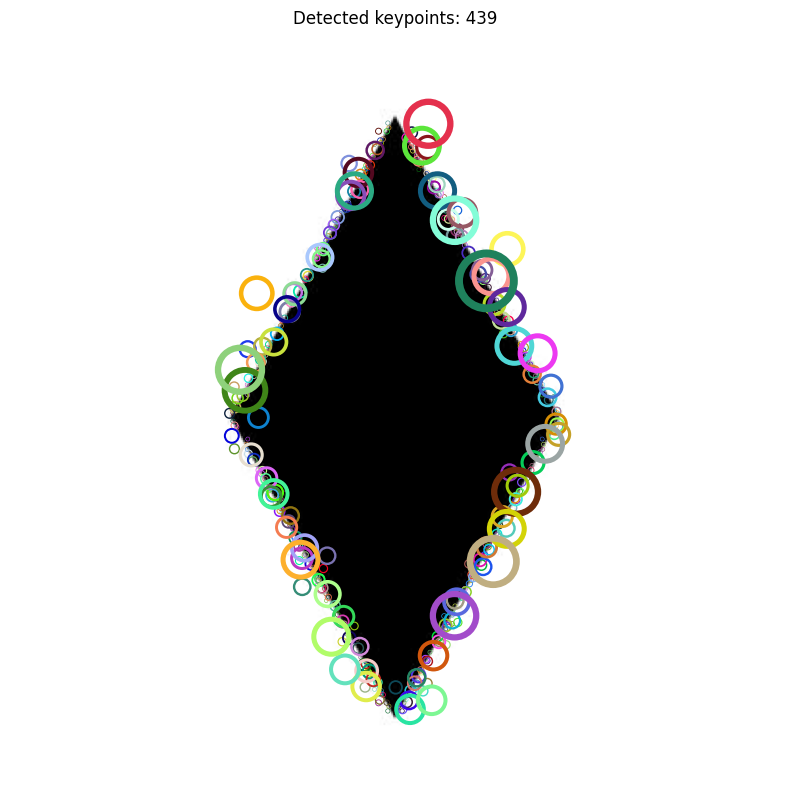

In [24]:
# If original_img is grayscale, convert to RGB for colorful plotting
if len(og_img.shape) == 2:
    img_rgb = cv2.cvtColor(og_img, cv2.COLOR_GRAY2RGB)
else:
    img_rgb = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
ax = plt.gca()

for (x, y, sigma) in keypoints_scaled:
    # Draw circle: radius can be sigma multiplied by a factor for better visibility
    circle = plt.Circle((y, x), sigma * 0.5, color=np.random.rand(3), fill=False, linewidth=0.2 * sigma)
    ax.add_patch(circle)

plt.axis('off')
plt.title(f'Detected keypoints: {len(keypoints_scaled)}')
plt.show()

5638


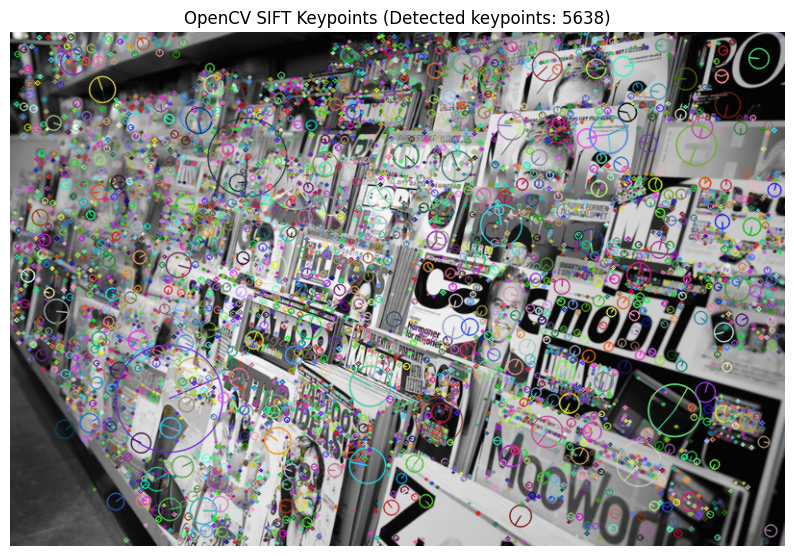

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load an image in grayscale
img = og_img.copy()

# Initialize OpenCV's SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)
print(len(keypoints))

# Draw keypoints
img_with_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show result
plt.figure(figsize=(10,10))
plt.imshow(img_with_kp, cmap='gray')
plt.title('OpenCV SIFT Keypoints (Detected keypoints: {})'.format(len(keypoints)))
plt.axis('off')
plt.show()


4.211682025698662
111.36506652832031


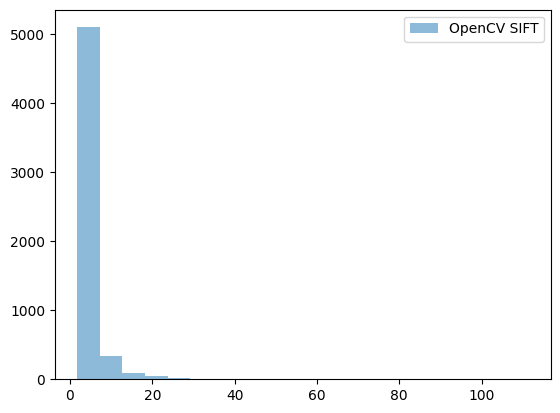

In [6]:
sizes = []
for keypoint in keypoints:
    sizes.append(keypoint.size)

print(np.mean(sizes))
print(np.max(sizes))

# my_sizes = []
# for keypoint in keypoints_scaled:
#     my_sizes.append(keypoint[2])

# print(np.mean(my_sizes))

# Plot sizes in same plot
plt.hist(sizes, bins=20, alpha=0.5, label='OpenCV SIFT')
# plt.hist(my_sizes, bins=20, alpha=0.5, label='My SIFT')
plt.legend()
plt.show()

